# **DSC Europe 2020 - Bayesian regression with TFP**

Now that we are familiar with the basics of TFP and MCMC sampling, we are ready to build our model. For this tutorial, we will be building a simple 2D linear regression model of an N-rank polynomial. As a quick reminder, this kind of model follows form:

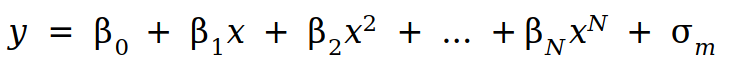

where N is the rank of the polynomial, β0-βN are the regression coefficients, and σ is the model uncertainty.


## Specifying a probabilistic model



### Initial Setup

No matter the specific model, we first need some boilerplate code for running imports and seeding random number generators. We will also install the latest
version of `plotly` to enable to extra plotting functionality.


In [ ]:
%pip install "plotly>=4.12"

     |████████████████████████████████| 13.1MB 322kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

# Assigning an alias to this library since we will be calling it often
tfd = tfp.distributions

## Using plotly for plotting
import plotly.express as plx
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pprint import pprint

### Dataset Generation

Let's first write a simple function to create idealized, noise-free data from a polynomial. Then, we can add some random noise to make the dataset a bit
more realistic.

In [ ]:
def forward_model(x_values, coefficients):
    """
    An N rank polynomial, where N is determined by the length of the provided
    coefficients tensor.

    Args:
        x_values (tf.Tensor): The points at which to evaluate the polynomial
        coefficients (tf.Tensor): The polynomial's beta coefficients
    """
    return tf.math.polyval(tf.unstack(coefficients), x_values)

# Data X values
x_values = tf.linspace(-2.0, 4.0, 25)

# True beta coefficients for our polynomial
true_coefficients = tf.constant(np.array([2.0, -4.0, 1.0, 1.5]), tf.float32)

# True standard deviation for the modelization uncertainty.
true_sigma = 6.0

# Dataset with NO noise
idealized_data = forward_model(x_values, true_coefficients)

# Dataset with random noise added
y_values = tfd.Normal(loc=idealized_data, scale=true_sigma).sample()

Let's quickly plot the data:

In [ ]:
equation = "y = "
for i, b in enumerate(true_coefficients.numpy()):
  if i == 0:
    equation += f"({b})"
  elif i == 1:
    equation += f" + ({b})x"
  else:
    equation += f" + ({b})x^{i}"

fig = plx.scatter(x=x_values, y=y_values)
fig.update_layout(title=f"Dataset with noise for polynomial:     {equation}")
fig.show()

### Model definition
Now we are ready to start specifying our model. As a reminder, our data consists of (x, y) observations (stored in the `x_values` and `y_values` tensors), and our model parameters are the polynomial's coefficients as well as 
the model uncertainty. In Bayesian modeling, we will pretty much always need to 
include model uncertainty as a parameter since it is rarely a known value.

As discussed in the earlier slides, we need to define two parts of our model: 

1. The likelihood function, `L(data | model)`, and 
2. Priors for our model parameters.




#### Likelihood

Let's start with the likelihood function, which we will *assume* to be gaussian. Note that we will be working in log-space when defining our likelihood and prior distributions. This is a common approach in MCMC sampling where the exceedingly low posterior probabilities encountered during sampling often result in numerical underflow issues.


In [ ]:
def log_likelihood(x_values, y_values, coefficients, sigma):
    idealized_data = forward_model(x_values, coefficients)
    log_likelihoods = tfd.Normal(loc=idealized_data, scale=sigma).log_prob(y_values)
    # Note that we are **adding** and not multiplying the likelihoods below since 
    # we are in log-space.
    return tf.math.reduce_sum(log_likelihoods)

Vectorisation is an important concept in TensorFlow and TensorFlow Probability:
While it looks as if we are setting up only a single Normal distribution with the call to `tfd.Normal()`, the shape of `idealized_data` in fact tells TensorFlow Probability that we really want multiple normal distributions but to treat them in parallel.

In that spirit, `log_likelihoods` is a tensor of the same shape as `idealized_data`, which we sum into a tensor of length one in the last line.  


#### Priors

To complete our posterior distribution, we have to specify prior distributions for all parameters. 

We choose the prior distributions for the coefficients to be somewhat broad (i.e. weakly informative) normal distributions since we don't know much about the possible values of the regression coefficients.

We set the prior distribution of sigma to be a log-normal distribution. It has positive support, which captures the fact that the standard deviation by definition must be positive.

In [ ]:
def log_prior(coefficients, sigma):
    """Combined log-prior probabilities for all coefficients and sigma"""
    log_coefficients_prior = tfd.Normal(loc=0.0, scale=5.0).log_prob(coefficients)
    log_sigma_prior = tfd.LogNormal(loc=2, scale=.5).log_prob(sigma)
    return tf.math.reduce_sum(log_coefficients_prior) + log_sigma_prior

#### Posterior

Now we're ready to stitch together our posterior distribution, binding the data to the x and y values we generated earlier:

In [ ]:
def log_posterior(parameters):
    coefficients = parameters[:-1]
    sigma = parameters[-1]
    return log_likelihood(x_values, y_values, coefficients, sigma) + log_prior(coefficients, sigma)

## Markov Chain Monte Carlo (MCMC) sampling

To sample from this posterior using MCMC, we need an initial state for the Markov chain:

In [ ]:
initial_state = np.array([0.0, 0.0, 0.0, 0.0, 1.0], dtype=np.float32)

In TFP, the type of MCMC sampling algorithm you want to use is specified by the transition kernel.

Let's initialize a [random walk Metropolis](https://www.tweag.io/blog/2019-10-25-mcmc-intro1/) transition kernel.

In [ ]:
kernel = tfp.mcmc.RandomWalkMetropolis(
    # Our posterior function from above
    target_log_prob_fn=log_posterior, 

    # MCMC algorithms require a function which proposes new states for 
    # the chain on each iteration (i.e. new parameter values). Here we
    # use the builtin `random_walk_normal_fn` which proposes a new random
    # value for each parameter using a normal distribution
    # centered around the current value with a fixed standard deviation=1.
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1)
)

We're almost there:
we now create a helper function which runs the Markov chain:

In [ ]:
@tf.function
def run_chain(initial_state, num_samples=10000, num_burnin_steps=1000):
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=10,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

Two interesting things appear here:
- the `@tf.function` decorator makes TensorFlow build a static compute graph from the `run_chain()` function. That is a huge speed gain.
- the `trace_fn` argument to `sample_chain()` determines what information is stored after each MCMC transition. In our case, we are interested in the transition kernel results, which tell us. e.g., whether a MCMC move was accepted or not.

Now we finally are able to draw samples:

In [ ]:
samples, kernel_results = run_chain(initial_state)

Let's look at the acceptance rate to see whether we set the transition kernel parameters to sensible values:

In [ ]:
kernel_results.is_accepted.numpy().sum() / len(kernel_results.is_accepted)

0.5798

Looks good!  

Let's look at the histograms:

In [ ]:
samples_array = samples.numpy()
fig = make_subplots(rows=1, cols=samples_array.shape[1])
for i in range(samples_array.shape[1]):
  mean = samples_array[:, i].mean()
  if i < samples_array.shape[1] - 1:
    title = f"beta_{i}"
  else:
    title = "sigma"
  hist = go.Histogram(x=samples_array[:, i], name=title)
  fig.append_trace(hist, 1, i+1)
  if i < samples_array.shape[1] - 1:
    actual = true_coefficients.numpy()[i]
    fig.add_vline(actual, 1, i + 1, annotation_text=f"Actual={actual:.2}", annotation_position="bottom right", line={"color":"black"})
  else:
    fig.add_vline(true_sigma, 1, i + 1, annotation_text=f"Actual={true_sigma:.2}", annotation_position="bottom right", line={"color":"black"})
  fig.add_vline(mean, 1, i + 1, annotation_text=f"Mean={mean:.2}", line={"color":"red"})

fig.update_layout(title="Posterior samples")

We can also transform our coefficient samples into lines to see how well it fits our data.

In [ ]:
xspace = np.linspace(min(x_values), max(x_values), 100)
f_samples = []
# Thin the chain to every X samples for plotting
take_every = 10
for params in samples_array[0::take_every]:
    coefficients = params[:-1]
    f_samples.append(np.vstack((xspace, np.polyval(coefficients, xspace))))
f_samples = np.hstack(f_samples)

fig = go.Figure(
    go.Histogram2d(
        x=f_samples[0, :],
        y=f_samples[1, :], 
        opacity=0.6, 
        nbinsx=100,
        nbinsy=100,
        colorscale="reds",
        colorbar={"title": 'Count', "tick0": "log"},
        name="Posterior samples",
    )
)
fig.add_scatter(x=x_values, y=y_values, mode="markers", marker={"color": "black"}, name="Actual Data")
fig.update_xaxes(range=[min(x_values), max(x_values)])
fig.update_layout(title="Posterior samples", xaxis_title="X", yaxis_title="Y",)
fig.show()

### Exercise 1

Adjust the values of the `initial_state` tensor above and re-run the sampling. 
Do the estimates for the coefficients look different?

## Model Diagnostics

You might have noticed in the histograms above that some of our posterior predictions don't line up perfectly with the true values. This raises an important question: how do we diagnose our model's performance? Are we sure that
we've sampled most of the posterior distribution, or did our sampler get stuck
in a local maximum? Let's take a look at a few tools we can use to diagnose
our model's performance.

#### Convergence

As noted above, one point of concern is whether we have effectively explored the
posterior distribution. Just like other optimisation algorithms, MCMC algorithms
can potentially get stuck in tricky regions of the posterior (e.g. local maxima). 

The standard way of diagnosing this issue is to run several chains, each with
different initialization points, and to compute the [Gelman-Rubin](https://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) diagnostic (also known as r-hat). 

TFP provides a helper function for doing this, but first we need to update our model run to be able to handle running multiple chains. Since each of the chains is independent, this can be vectorized and executed in parallel.

In [ ]:
def forward_model(x_values, coefficients):
    return tf.vectorized_map(lambda c: tf.math.polyval(tf.unstack(c), x_values), coefficients)


def log_likelihood(x_values, y_values, coefficients, sigma):
    idealized_data = forward_model(x_values, coefficients)
    sigma = tf.ones((coefficients.shape[0], x_values.shape[0])) * sigma[:, None]
    log_likelihoods = tfd.Normal(loc=idealized_data, 
                                 scale=sigma).log_prob(y_values)
    return tf.math.reduce_sum(log_likelihoods, axis=1)


def log_prior(coefficients, sigma):
    log_coefficients_prior = tfd.Normal(loc=0.0, scale=5.0).log_prob(coefficients)
    log_sigma_prior = tfd.LogNormal(loc=2, scale=5).log_prob(sigma)
    return tf.math.reduce_sum(log_coefficients_prior, axis=1) + log_sigma_prior


def log_posterior(parameters):
    coefficients = parameters[:,:-1]
    sigma = parameters[:,-1]

    l = log_likelihood(x_values, y_values, coefficients, sigma) 
    p = log_prior(coefficients, sigma)
    
    return l + p

kernel = tfp.mcmc.RandomWalkMetropolis(
    # Our posterior function from above
    target_log_prob_fn=log_posterior, 

    # MCMC algorithms require a function which proposes new states for 
    # the chain on each iteration (i.e. new parameter values). Here we
    # use the builtin `random_walk_normal_fn` which proposes a new random
    # value for each parameter using a normal distribution
    # centered around the current value with a fixed standard deviation=1.
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1)
)   

@tf.function
def run_chain(initial_state, num_samples=10000, num_burnin_steps=1000):
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=10,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

Now, we just need to define the initial state of our chains and run the sampling.

In [ ]:
n_chains = 4

def mk_init_state():
  return np.array([
    np.random.uniform(-2, 2), # beta0
    np.random.uniform(-2, 2), # beta1
    np.random.uniform(-2, 2), # beta2
    np.random.uniform(-2, 2), # beta3
    np.random.uniform(0, 1)   # sigma
    ], dtype=np.float32
  )

initial_state = np.vstack([mk_init_state() for _ in range(n_chains)])
pprint(initial_state)

array([[-0.5018395 ,  1.8028573 ,  0.9279758 ,  0.39463395,  0.15601864],
       [-1.3760219 , -1.7676655 ,  1.4647046 ,  0.40446004,  0.7080726 ],
       [-1.917662  ,  1.8796394 ,  1.3297706 , -1.1506436 ,  0.18182497],
       [-1.266382  , -0.78303105,  0.09902573, -0.27221993,  0.29122913]],
      dtype=float32)


In [ ]:
samples, kernel_results = run_chain(initial_state)

Now we can check the r-hat diagnostic for each of our model parameters, which should be close to 1 if the chains have converged.

In [ ]:
rhat = tfp.mcmc.potential_scale_reduction(samples)
print(rhat)

tf.Tensor([1.0393724 1.056996  1.0279936 1.128554  1.0127888], shape=(5,), dtype=float32)


#### Exercise 2

Adjust the initial states above and see if/how the value for rhat changes. Are you able to find initial states which prevent the chains from converging (i.e. high rhat values)? 

#### Prior Predictive Checks

Priors play an important role in Bayesian modeling, and in models with many parameters it can be hard to imagine how they will affect your final posterior predictions. 

A great sanity check for your priors is to use them to generate new data points. Then, you can compare these data points with your real data to make sure that you priors are saying what you expect them to. This process is called a prior predictive check. Let's try it out for our model.

In [ ]:
# We'll need to code this up ourselves since TFP doesn't provide helpers for
# prior predictive checks. 

# Draw prior samples
n_pp_samples = 200

range_x = np.linspace(-10, 10, 500)

prior_betas = tfd.Normal(
  loc=[0, 0, 0, 0], # [2, -4, 1, 1.5]
  scale=[5, 5, 5, 5] # [1, 1, 1, 1]
)
prior_sigma = tfd.LogNormal(loc=2, scale=.5)

pp_data = []
xs = tf.convert_to_tensor(range_x, dtype=float)
for i in tf.range(n_pp_samples):
  # Simulate a set of model parameters using our priors
  betas = prior_betas.sample()
  sigma = prior_sigma.sample()
  # Transform that sample into a data prediction
  ys = tf.math.polyval(tf.unstack(betas), xs)
  # Which we can use to simulate data
  simulated_data_dist = tfd.Normal(ys, scale=sigma)
  simulated_data = simulated_data_dist.sample()
  pp_data.append(np.vstack((range_x, simulated_data.numpy())))
pp_data = np.hstack(pp_data)

In [ ]:
fig = go.Figure(
    go.Histogram2d(
        x=pp_data[0, :],
        y=pp_data[1, :], 
        opacity=0.6, 
        nbinsx=175,
        ybins={"end":120, "size":5, "start": -50},
        colorscale="reds",
        colorbar={"title": 'Count', "tick0": "log"},
        name="Prior predictive samples",
    )
)
fig.add_scatter(x=x_values, y=y_values, mode="markers", marker={"color": "black"}, name="Actual Data")
fig.update_xaxes(range=[min(x_values), max(x_values)])
fig.update_yaxes(range=[min(y_values), max(y_values)])
fig.update_layout(title="Prior Predictive", xaxis_title="X", yaxis_title="Y",)
fig.show()

#### Effective Sample Size

While our goal is to obtain independent samples of our model's posterior distribution, it turns out that MCMC algorithms often produce samples which
are autocorrelated. This means that samples near each other in the markov chain are actually correlated, and the *effective* sample size of our chain is less than the total number of samples.

To help evaluate whether we have a large enough sample size, we can calculate 
the autocorrelation of samples in our chain and use a threshold to estimate the number of independent samples.

TFP provides a handy convenience method for checking the effective sample size:

In [ ]:
tfp.mcmc.effective_sample_size(samples)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 71.52828 ,  56.916824,  77.46225 ,  33.479507, 103.38926 ],
      dtype=float32)>

#### Thinning

Sometimes, MCMC samplers must be run for an exceedingly high number of iterations to adequately sample a probability distribution. In these cases, it can sometimes be useful to *thin* your MCMC samples by selecting every Nth sample from your Markov Chain. While being a fairly common practice, this should only be done in cases where your sample size is prohibitively large (e.g. due to limited computational resources) since it reduces the precision of your estimates.

## Wrapping Up

This has been only a brief tour of the power of MCMC sampling. TensorFlow probability also implements a number of other MCMC samplers including Hamiltonian Monte Carlo (HMC), No U-Turn (NUTS), Replica Exchange, and more. Check out the [tfp.mcmc](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc) documentation for more info. 

We hope you've enjoyed this tutorial! Please feel free to reach out to use if you have any questions.

Thanks!

### Other Resources

TensorFlow Probability is not the only framework for bayesian modeling. Two well-known alternatives are PyMC3 and Stan, both of which have active online communities where you can also discuss more general Bayesian modeling questions.
The Stan users manual is also a great resource for understanding some common
types of models.

https://mc-stan.org/docs/2_19/stan-users-guide/example-models-part.html#example-models.part

https://discourse.pymc.io/

https://discourse.mc-stan.org/
